In [1]:
import tempfile
from pathlib import Path

import boto3
import pandas as pd

bucket = "ml-for-bem"
bucket_prefix = "hatchet"
experiment_id = "test/progressive-training-26"
experiment_id = "test/ma-lib-02"
experiment_id = "test/new-dockerfile-3"
experiment_id = "ma-webapp/v0"
experiment_id = "ma-webapp/test/v1-20250410-113041"
experiment_id = "ma-webapp/v1-20250410-135156"
experiment_id = "ma-webapp/test/v2-20250507-141804"
experiment_id = "ma-webapp/v2-20250507-151630"
experiment_id = "ma-webapp/test/v2-20250508-122929-boston-only"
experiment_id = "ma-webapp/test/v3-20250514-135900-boston-only"
experiment_id = "ma-webapp/test/v3-20250524-131122-boston-only"
experiment_id = "ma-webapp/v3-20250524-134120"
experiment_id = "ma-webapp/v4-20250814-131043"
experiment_id = "ma-webapp/v4-20250814-163347"

s3 = boto3.client("s3")

# list all the files in the experiment directory that have "train" and "results" and "h5" in the key
files = s3.list_objects(Bucket=bucket, Prefix=f"{bucket_prefix}/{experiment_id}")[
    "Contents"
]

# filter the files to only include the ones that have "train" and "results" and "h5" in the key
train_err_h5_files = [
    file
    for file in files
    if "train/" in file["Key"] and "results" in file["Key"] and "h5" in file["Key"]
]


train_fold_err_keys = [file["Key"] for file in train_err_h5_files]

individual_fold_err_dfs = []
global_err_dfs = []
with tempfile.TemporaryDirectory() as temp_dir:
    for i, file in enumerate(train_fold_err_keys):
        local_path = Path(temp_dir) / f"result_{i}.h5"
        s3.download_file(Bucket=bucket, Key=file, Filename=local_path.as_posix())
        err_df = pd.read_hdf(local_path.as_posix(), key="stratum_metrics")
        global_err_df = pd.read_hdf(local_path.as_posix(), key="global_metrics")
        individual_fold_err_dfs.append(err_df)
        global_err_dfs.append(global_err_df)

individual_fold_err_dfs = pd.concat(individual_fold_err_dfs)
global_err_dfs = pd.concat(global_err_dfs)

train_pq_files = [file for file in files if "fold-averaged-errors" in file["Key"]]
train_pq_keys = [file["Key"] for file in train_pq_files]

fold_averaged_errs_df = pd.concat(
    [pd.read_parquet(f"s3://{bucket}/{key}").sort_index() for key in train_pq_keys],
    axis=1,
)

combined_sim_results_files = [
    file for file in files if "full-dataset.pq" in file["Key"]
]
final_combined_sim_results_key = combined_sim_results_files[-1]["Key"]
final_combined_sim_results_uri = f"s3://{bucket}/{final_combined_sim_results_key}"
combined_sim_results_df = pd.read_parquet(final_combined_sim_results_uri)

In [2]:
# combined_sim_results_df.to_parquet("E:/repos/carbon-signal-linear/data/sbem-v1.pq")

In [2]:
combined_sim_results_df.groupby("experiment_id").size()

experiment_id
ma-webapp/v4-20250814-163347/iter-000/sample    49942
ma-webapp/v4-20250814-163347/iter-001/sample    99883
ma-webapp/v4-20250814-163347/iter-002/sample    99874
ma-webapp/v4-20250814-163347/iter-003/sample    99880
dtype: int64

Text(0.5, 0.98, 'Heating and Cooling Demand by Month')

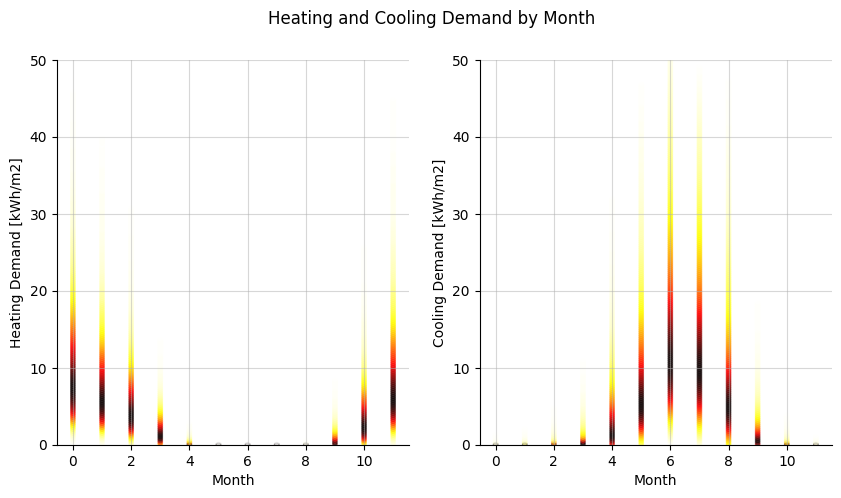

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

d = combined_sim_results_df["Energy"]["Raw"].sample(frac=0.1)


cmap = "hot_r"
h = d["Heating"]
h_max = h.max().max() * 1.1
c = d["Cooling"]
c_max = c.max().max() * 1.1
y_max = max(h_max, c_max)
y_max = 50
x = np.repeat(np.arange(12).reshape(1, -1), len(h), axis=0)

for i in range(12):
    ys = h.values[:, i]
    kde = gaussian_kde(ys)
    xs = np.linspace(0, y_max, 200)
    ax[0].scatter([i] * len(xs), xs, c=kde(xs), cmap=cmap, s=10, alpha=0.5)
ax[0].set_ylim(0, y_max)

x = np.repeat(np.arange(12).reshape(1, -1), len(c), axis=0)

for i in range(12):
    ys = c.values[:, i]
    kde = gaussian_kde(ys)
    xs = np.linspace(0, y_max, 200)
    ax[1].scatter([i] * len(xs), xs, c=kde(xs), cmap=cmap, s=10, alpha=0.5)
ax[1].set_ylim(0, y_max)
ax[0].set_ylabel("Heating Demand [kWh/m2]")
ax[1].set_ylabel("Cooling Demand [kWh/m2]")
ax[0].set_xlabel("Month")
ax[1].set_xlabel("Month")
ax[0].spines["top"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# add faint gridlines
ax[0].grid(True, alpha=0.5)
ax[1].grid(True, alpha=0.5)
plt.suptitle("Heating and Cooling Demand by Month")

Month,4,5,6,7,8,9,10
mean,2.458023,0.367724,0.029803,0.000838,0.003641,0.058840,1.220551
50%,1.921084,0.148586,0.000597,0.000000,0.000000,0.001489,0.740923
75%,3.230013,0.460484,0.014999,0.000000,0.000195,0.036485,1.613759


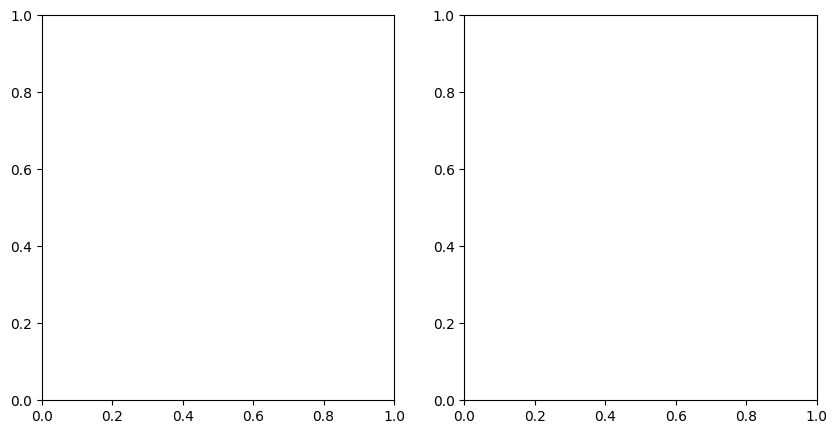

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

d = combined_sim_results_df["Energy"]["Raw"]
d["Heating"].reset_index(drop=True).describe()[[4, 5, 6, 7, 8, 9, 10]].loc[
    ["mean", "50%", "75%"]
]

Text(0.5, 0.98, 'Peak Heating and Cooling Demand by Month')

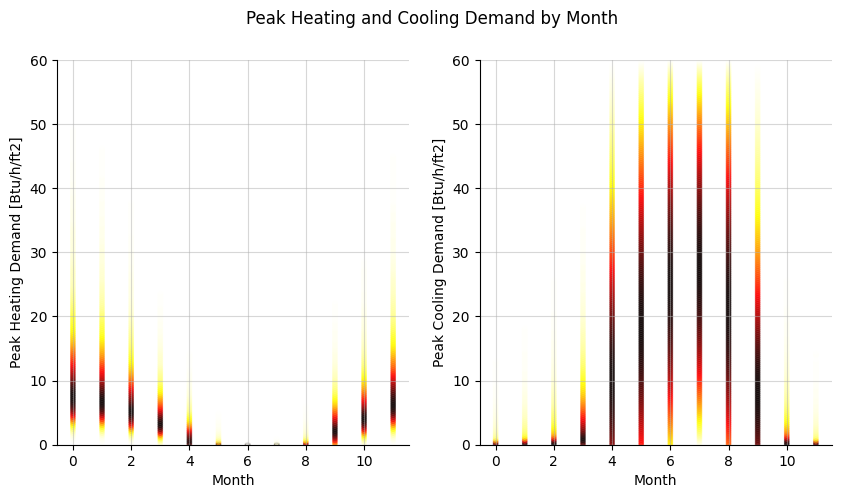

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

d = combined_sim_results_df["Peak"]["Raw"].sample(frac=0.1) * 1000 * 3.412 / 10.76391


cmap = "hot_r"
h = d["Heating"]
h_max = h.max().max() * 1.1
c = d["Cooling"]
c_max = c.max().max() * 1.1
y_max = max(h_max, c_max)
y_max = 60
x = np.repeat(np.arange(12).reshape(1, -1), len(h), axis=0)

for i in range(12):
    ys = h.values[:, i]
    kde = gaussian_kde(ys)
    xs = np.linspace(0, y_max, 200)
    ax[0].scatter([i] * len(xs), xs, c=kde(xs), cmap=cmap, s=10, alpha=0.5)
ax[0].set_ylim(0, y_max)

x = np.repeat(np.arange(12).reshape(1, -1), len(c), axis=0)

for i in range(12):
    ys = c.values[:, i]
    kde = gaussian_kde(ys)
    xs = np.linspace(0, y_max, 200)
    ax[1].scatter([i] * len(xs), xs, c=kde(xs), cmap=cmap, s=10, alpha=0.5)
ax[1].set_ylim(0, y_max)
ax[0].set_ylabel("Peak Heating Demand [Btu/h/ft2]")
ax[1].set_ylabel("Peak Cooling Demand [Btu/h/ft2]")
ax[0].set_xlabel("Month")
ax[1].set_xlabel("Month")
ax[0].spines["top"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)
ax[1].spines["right"].set_visible(False)
# add faint gridlines
ax[0].grid(True, alpha=0.5)
ax[1].grid(True, alpha=0.5)
plt.suptitle("Peak Heating and Cooling Demand by Month")

In [6]:
mask = combined_sim_results_df["Peak"]["Raw"]["Cooling"].max(axis=1) * 1000 > 2000
df_masked = combined_sim_results_df[mask]
feats = df_masked.index.to_frame(index=False)
sfeats = feats[[c for c in feats.columns if "semantic" in c.lower()]]
for col in sfeats.columns:
    print(col)
    print(sfeats[col].value_counts())
    print("\n")

semantic_fields_uri
semantic_fields_uri
s3://ml-for-bem/hatchet/ma-webapp/v4-20250814-163347/artifacts/semantic-fields.yml    40346
Name: count, dtype: int64


feature.semantic.DHW
feature.semantic.DHW
ElectricResistanceDHW        10136
NaturalGasDHW                10100
HPWH                         10079
NaturalGasHeatingDHWCombo    10031
Name: count, dtype: int64


feature.semantic.Walls
feature.semantic.Walls
FullInsulationWallsCavity            8180
FullInsulationWallsCavityExterior    8127
SomeInsulationWalls                  8101
UninsulatedWalls                     8021
SIP                                  7917
Name: count, dtype: int64


feature.semantic.Region
feature.semantic.Region
MA    40346
Name: count, dtype: int64


feature.semantic.Cooling
feature.semantic.Cooling
ACCentral      8173
ASHPCooling    8096
ACWindow       8092
GSHPCooling    8072
WindowASHP     7913
Name: count, dtype: int64


feature.semantic.Heating
feature.semantic.Heating
NaturalGasHeating             

Text(0, 0.5, 'Annual Cooling Energy [kWh/m2/yr]')

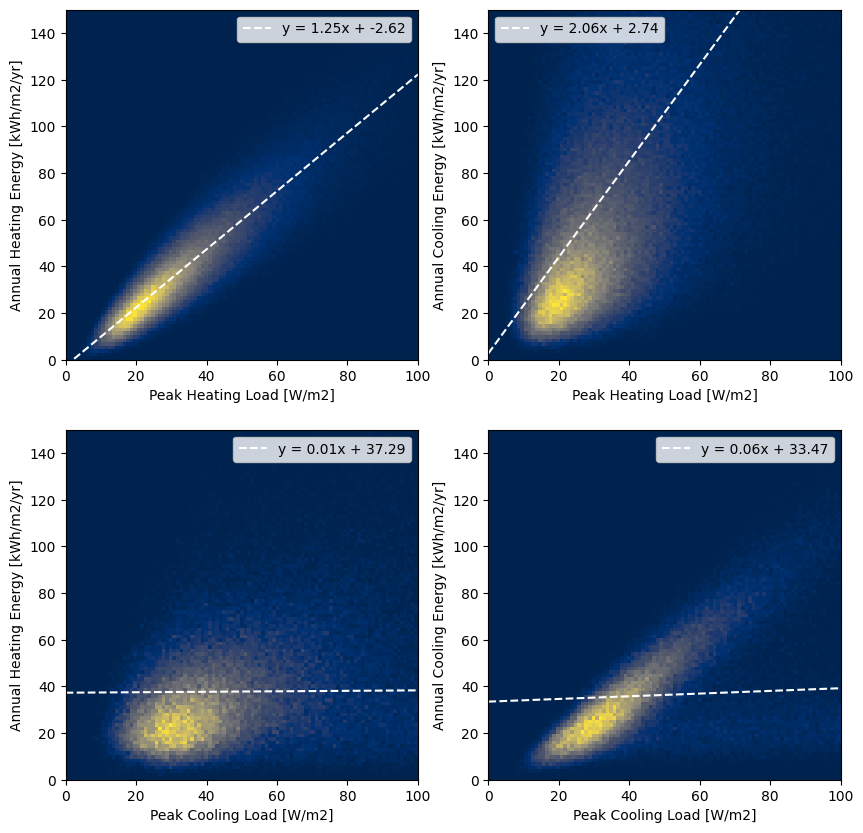

In [7]:
from sklearn.linear_model import LinearRegression

Qdot_hmax = combined_sim_results_df["Peak"]["Raw"]["Heating"].max(axis=1) * 1000
Qdot_cmax = combined_sim_results_df["Peak"]["Raw"]["Cooling"].max(axis=1) * 1000
Qhtot = combined_sim_results_df["Energy"]["Raw"]["Heating"].sum(axis=1)
Qctot = combined_sim_results_df["Energy"]["Raw"]["Cooling"].sum(axis=1)
Qtot = combined_sim_results_df["Energy"]["Utilities"].sum(axis=1)

hhmodel = LinearRegression()
hhmodel.fit(Qdot_hmax.values.reshape(-1, 1), Qhtot)
hcmodel = LinearRegression()
hcmodel.fit(Qdot_hmax.values.reshape(-1, 1), Qctot)
xhmax = 100
xh = np.linspace(0, xhmax, 100)
yhh = hhmodel.predict(xh.reshape(-1, 1))
yhc = hcmodel.predict(xh.reshape(-1, 1))

chmodel = LinearRegression()
chmodel.fit(Qdot_cmax.values.reshape(-1, 1), Qhtot)
ccmodel = LinearRegression()
ccmodel.fit(Qdot_cmax.values.reshape(-1, 1), Qctot)

xcmax = 100
xc = np.linspace(0, xcmax, 100)
ych = chmodel.predict(xc.reshape(-1, 1))
ycc = ccmodel.predict(xc.reshape(-1, 1))


fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# plt.scatter(Qdot_hmax, Qhtot, s=0.1, alpha=0.1)
_ = ax[0, 0].hist2d(
    Qdot_hmax,
    Qhtot,
    bins=(np.linspace(0, xhmax, 100), np.linspace(0, 150, 100)),
    cmap="cividis",
)
ax[0, 0].plot(
    xh,
    yhh,
    color="white",
    linestyle="--",
    label=f"y = {hhmodel.coef_[0]:.2f}x + {hhmodel.intercept_:.2f}",
)
ax[0, 0].legend()
ax[0, 0].set_xlabel("Peak Heating Load [W/m2]")
ax[0, 0].set_ylabel("Annual Heating Energy [kWh/m2/yr]")

_ = ax[0, 1].hist2d(
    Qdot_hmax,
    Qctot,
    bins=(np.linspace(0, xhmax, 100), np.linspace(0, 150, 100)),
    cmap="cividis",
)
ax[0, 1].plot(
    xh,
    yhc,
    color="white",
    linestyle="--",
    label=f"y = {hcmodel.coef_[0]:.2f}x + {hcmodel.intercept_:.2f}",
)
ax[0, 1].legend()
ax[0, 1].set_xlabel("Peak Heating Load [W/m2]")
ax[0, 1].set_ylabel("Annual Cooling Energy [kWh/m2/yr]")

_ = ax[1, 0].hist2d(
    Qdot_cmax,
    Qhtot,
    bins=(np.linspace(0, xcmax, 100), np.linspace(0, 150, 100)),
    cmap="cividis",
)
ax[1, 0].plot(
    xc,
    ych,
    color="white",
    linestyle="--",
    label=f"y = {chmodel.coef_[0]:.2f}x + {chmodel.intercept_:.2f}",
)
ax[1, 0].legend()
ax[1, 0].set_xlabel("Peak Cooling Load [W/m2]")
ax[1, 0].set_ylabel("Annual Heating Energy [kWh/m2/yr]")

_ = ax[1, 1].hist2d(
    Qdot_cmax,
    Qctot,
    bins=(np.linspace(0, xcmax, 100), np.linspace(0, 150, 100)),
    cmap="cividis",
)
ax[1, 1].plot(
    xc,
    ycc,
    color="white",
    linestyle="--",
    label=f"y = {ccmodel.coef_[0]:.2f}x + {ccmodel.intercept_:.2f}",
)
ax[1, 1].legend()
ax[1, 1].set_xlabel("Peak Cooling Load [W/m2]")
ax[1, 1].set_ylabel("Annual Cooling Energy [kWh/m2/yr]")


# _ = plt.hist2d(
#     Qdot_hmax,
#     Qtot,
#     cmap="cividis",
#     bins=(np.linspace(0, 140, 100), np.linspace(0, 300, 100)),
# )
# # plt.plot(x, y, color="white", linestyle="--", label=f"y = {model.coef_[0]:.2f}x + {model.intercept_:.2f}")
# plt.show()

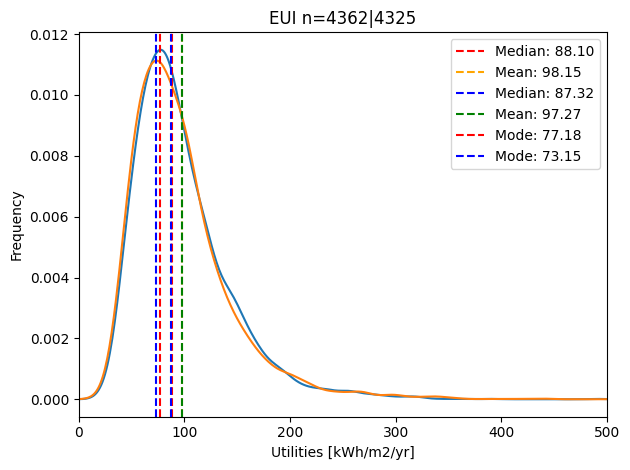

In [8]:
from scipy.stats import gaussian_kde

bins = 20

# walls = "SomeInsulationWalls"
# weatherization = "SomewhatLeakyEnvelope"
# windows = "SinglePane"
walls = "FullInsulationWallsCavity"
weatherization = "TightEnvelope"
windows = "TriplePaneLowE"

d1 = (
    combined_sim_results_df.xs(walls, level="feature.semantic.Walls")
    .xs(weatherization, level="feature.semantic.Weatherization")
    .xs(windows, level="feature.semantic.Windows")
)

walls = "FullInsulationWallsCavityExterior"
weatherization = "TightEnvelope"
windows = "TriplePaneLowE"
d2 = (
    combined_sim_results_df.xs(walls, level="feature.semantic.Walls")
    .xs(weatherization, level="feature.semantic.Weatherization")
    .xs(windows, level="feature.semantic.Windows")
)
# mask = (
#     d.index.get_level_values("feature.semantic.Heating")
#     .str.lower()
#     .str.contains(heating)
# )
# d = d[mask]
# mask = ~d.index.get_level_values(
#     "feature.semantic.Distribution"
# ).str.lower().str.contains("uninsulated") & ~d.index.get_level_values(
#     "feature.semantic.Distribution"
# ).str.lower().str.contains("steam")
# d = d[mask]
# d = d["Energy"]["Utilities"]["NaturalGas"].sum(axis=1)
d1 = d1["Energy"]["End Uses"].sum(axis=1)
d2 = d2["Energy"]["End Uses"].sum(axis=1)
d1kde = gaussian_kde(d1)
d2kde = gaussian_kde(d2)
test_locs = np.linspace(50, 200, 150)
d1kde_probs = d1kde(test_locs)
d2kde_probs = d2kde(test_locs)
d1_mode = test_locs[np.argmax(d1kde_probs)]
d2_mode = test_locs[np.argmax(d2kde_probs)]
median1 = d1.median()
mean1 = d1.mean()
median2 = d2.median()
mean2 = d2.mean()
fig, ax = plt.subplots()
d1.plot.kde(ax=ax)
d2.plot.kde(ax=ax)

ax.axvline(median1, color="red", linestyle="--", label=f"Median: {median1:.2f}")
ax.axvline(mean1, color="orange", linestyle="--", label=f"Mean: {mean1:.2f}")
ax.axvline(median2, color="blue", linestyle="--", label=f"Median: {median2:.2f}")
ax.axvline(mean2, color="green", linestyle="--", label=f"Mean: {mean2:.2f}")
ax.axvline(d1_mode, color="red", linestyle="--", label=f"Mode: {d1_mode:.2f}")
ax.axvline(d2_mode, color="blue", linestyle="--", label=f"Mode: {d2_mode:.2f}")

ax.set_xlabel("Utilities [kWh/m2/yr]")
ax.set_ylabel("Frequency")
ax.set_title(f"EUI n={len(d1)}|{len(d2)}")
ax.legend()
# create whitespace to the right of the plot to add a longer text description of the semantic features in the plot
# fig.text(
#     1.05,
#     0.5,
#     f"D1\nWalls := {walls}\nWeatherization := {weatherization}\nWindows := {windows}\n",
#     ha="left",
#     va="center",
#     wrap=False,
# )
ax.set_xlim(0, 500)
fig.tight_layout()

Text(0.5, 1.0, 'Percentage of Buildings with Peak Heating Demand in Each Month')

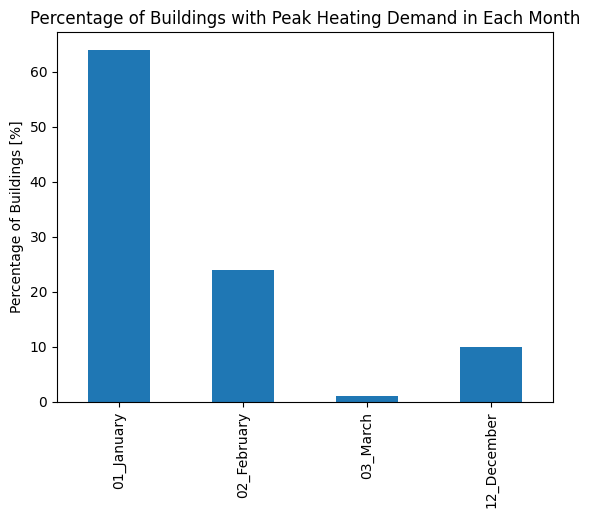

In [9]:
fig, ax = plt.subplots()
(
    combined_sim_results_df["Peak"]["Raw"]["Heating"].idxmax(axis=1).value_counts()
    / len(combined_sim_results_df)
    * 100
).round().rename({
    1: "01_January",
    2: "02_February",
    3: "03_March",
    4: "04_April",
    5: "05_May",
    6: "06_June",
    7: "07_July",
    8: "08_August",
    9: "09_September",
    10: "10_October",
    11: "11_November",
    12: "12_December",
}).sort_index().plot.bar(ax=ax)
plt.ylabel("Percentage of Buildings [%]")
plt.title("Percentage of Buildings with Peak Heating Demand in Each Month")

## Checking Learning Curves

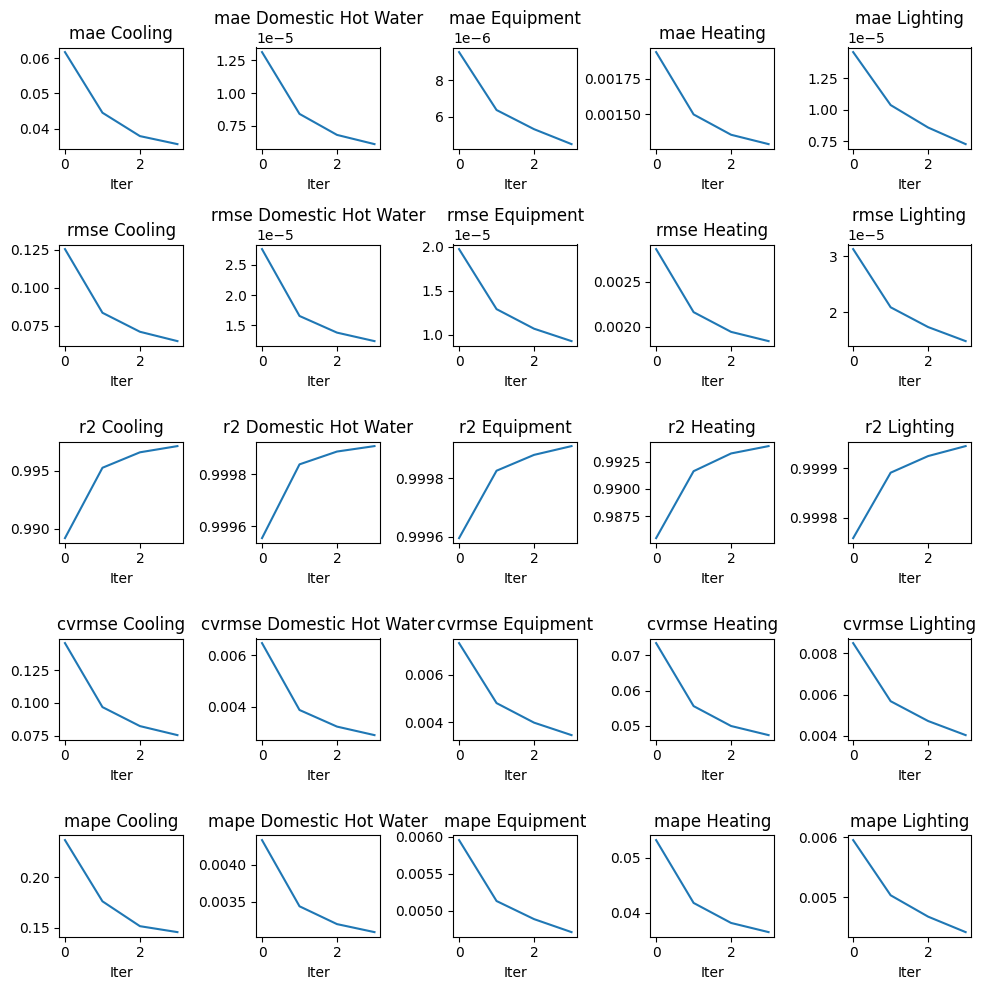

In [10]:
import matplotlib.pyplot as plt

global_errs = (
    global_err_dfs["test"].loc["Peak"].groupby("progressive_training_iter_ix").mean()
)
n_err_metrics = global_errs.columns.get_level_values("metric").nunique()
n_targets = global_errs.columns.get_level_values("target").nunique()
fig, ax = plt.subplots(n_err_metrics, n_targets, figsize=(10, 10))
for i, metric in enumerate(global_errs.columns.get_level_values("metric").unique()):
    for j, target in enumerate(global_errs.columns.get_level_values("target").unique()):
        global_errs[metric, target].plot(ax=ax[i, j])
        ax[i, j].set_title(f"{metric} {target}")
        ax[i, j].set_xlabel("Iter")
fig.tight_layout()

In [11]:
global_err_df

split_segment                                           train  \
metric                                                    mae   
target                                                Cooling   
measurement sort_index progressive_training_iter_ix             
Energy      0          3                             2.449710   
Peak        0          3                             0.025353   
Energy      1          3                             2.454813   
Peak        1          3                             0.023867   
Energy      2          3                             2.266931   
Peak        2          3                             0.021429   
Energy      3          3                             2.442195   
Peak        3          3                             0.024868   
Energy      4          3                             2.083746   
Peak        4          3                             0.024883   

split_segment                                                           \
metric                                                                   
target                                              Domestic Hot Water   
measurement sort_index progressive_training_iter_ix                      
Energy      0          3                                      0.016986   
Peak        0          3                                      0.000005   
Energy      1          3                                      0.019131   
Peak        1          3                                      0.000006   
Energy      2          3                                      0.014184   
Peak        2          3                                      0.000004   
Energy      3          3                                      0.014624   
Peak        3          3                                      0.000005   
Energy      4          3                                      0.013532   
Peak        4          3                                      0.000005   

split_segment                                                            \
metric                                                                    
target                                              Equipment   Heating   
measurement sort_index progressive_training_iter_ix                       
Energy      0          3                             0.018112  1.149674   
Peak        0          3                             0.000003  0.000951   
Energy      1          3                             0.021777  1.147168   
Peak        1          3                             0.000003  0.000901   
Energy      2          3                             0.022463  1.158831   
Peak        2          3                             0.000004  0.000889   
Energy      3          3                             0.018226  1.149088   
Peak        3          3                             0.000004  0.000974   
Energy      4          3                             0.022171  1.251962   
Peak        4          3                             0.000004  0.000965   

split_segment                                                            \
metric                                                             rmse   
target                                               Lighting   Cooling   
measurement sort_index progressive_training_iter_ix                       
Energy      0          3                             0.015300  3.346812   
Peak        0          3                             0.000005  0.036749   
Energy      1          3                             0.017996  3.359631   
Peak        1          3                             0.000006  0.034376   
Energy      2          3                             0.015677  3.087204   
Peak        2          3                             0.000005  0.030723   
Energy      3          3                             0.015764  3.345038   
Peak        3          3                             0.000006  0.036012   
Energy      4          3                             0.019393  2.832674   
Peak        4          3  

In [12]:
global_err_df.loc["Energy"].groupby("progressive_training_iter_ix").mean()[
    "test"
].stack("metric").T

C:\Users\szvsw\AppData\Local\Temp\ipykernel_2896\3279416211.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  ].stack("metric").T


progressive_training_iter_ix         3                                        
metric                          cvrmse       mae      mape        r2      rmse
target                                                                        
Cooling                       0.066048  3.406610  0.053186  0.995260  5.477988
Domestic Hot Water            0.002905  0.019580  0.001499  0.999910  0.039842
Equipment                     0.003456  0.025901  0.001792  0.999910  0.053207
Heating                       0.056507  1.787020  0.046890  0.993296  2.595661
Lighting                      0.004017  0.020662  0.002253  0.999946  0.042468

In [13]:
(
    individual_fold_err_dfs.loc["Peak"]["test"]
    .xs("mape", level="metric", axis=1)
    .xs("Heating", level="target", axis=1)
    .groupby("progressive_training_iter_ix")
    .mean()
    .T
    < 0.05
).mean()

progressive_training_iter_ix
0    0.203390
1    0.966102
2    1.000000
3    1.000000
dtype: float64

In [14]:
individual_fold_err_dfs.loc["Energy"]["test"].xs("mape", level="metric", axis=1).xs(
    "Heating", level="target", axis=1
).groupby("progressive_training_iter_ix").mean().T

progressive_training_iter_ix,0,1,2,3
stratum,,,,
USA_CT_Hartford-Bradley.Intl.AP.725080_TMYx.2007-2021,0.070772,0.053797,0.046941,0.044824
USA_CT_Windham.AP.725084_TMYx.2004-2018,0.068035,0.050047,0.047823,0.044094
USA_MA_Barnstable.Muni.AP-Boardman.Polando.Field.725067_TMYx,0.071635,0.057642,0.054451,0.052474
USA_MA_Barnstable.Muni.AP-Boardman.Polando.Field.725067_TMYx.2004-2018,0.066544,0.052832,0.051230,0.047223
USA_MA_Bedford-Hanscom.Field.AP.744900_TMYx.2007-2021,0.067531,0.054240,0.048914,0.045673
USA_MA_Beverly.Rgnl.AP.725088_TMYx.2004-2018,0.065006,0.049868,0.046703,0.042804
USA_MA_Beverly.Rgnl.AP.725088_TMYx.2007-2021,0.072152,0.056469,0.051959,0.047110
USA_MA_Blue.Hill.Obs.Science.Center.744907_TMYx.2004-2018,0.070525,0.054925,0.049646,0.045364
USA_MA_Borden.Flats.Light.Marina.997273_TMYx.2004-2018,0.075266,0.061676,0.055910,0.051602


In [15]:
fold_averaged_errs_df.xs("Peak", level="measurement").xs("r2", level="metric").groupby(
    "target"
).min().round(3)

,0,1,2,3
target,,,,
Cooling,-0.856,-0.058,0.472,0.503
Domestic Hot Water,0.995,0.999,1.000,1.000
Equipment,0.999,1.000,1.000,1.000
Heating,0.973,0.984,0.986,0.987
Lighting,0.999,1.000,1.000,1.000


In [16]:
fold_averaged_errs_df.xs("Peak", level="measurement").xs("mae", level="metric").groupby(
    "target"
).max().round(4)

,0,1,2,3
target,,,,
Cooling,0.1599,0.1050,0.0869,0.0800
Domestic Hot Water,0.0000,0.0000,0.0000,0.0000
Equipment,0.0000,0.0000,0.0000,0.0000
Heating,0.0029,0.0019,0.0017,0.0016
Lighting,0.0000,0.0000,0.0000,0.0000


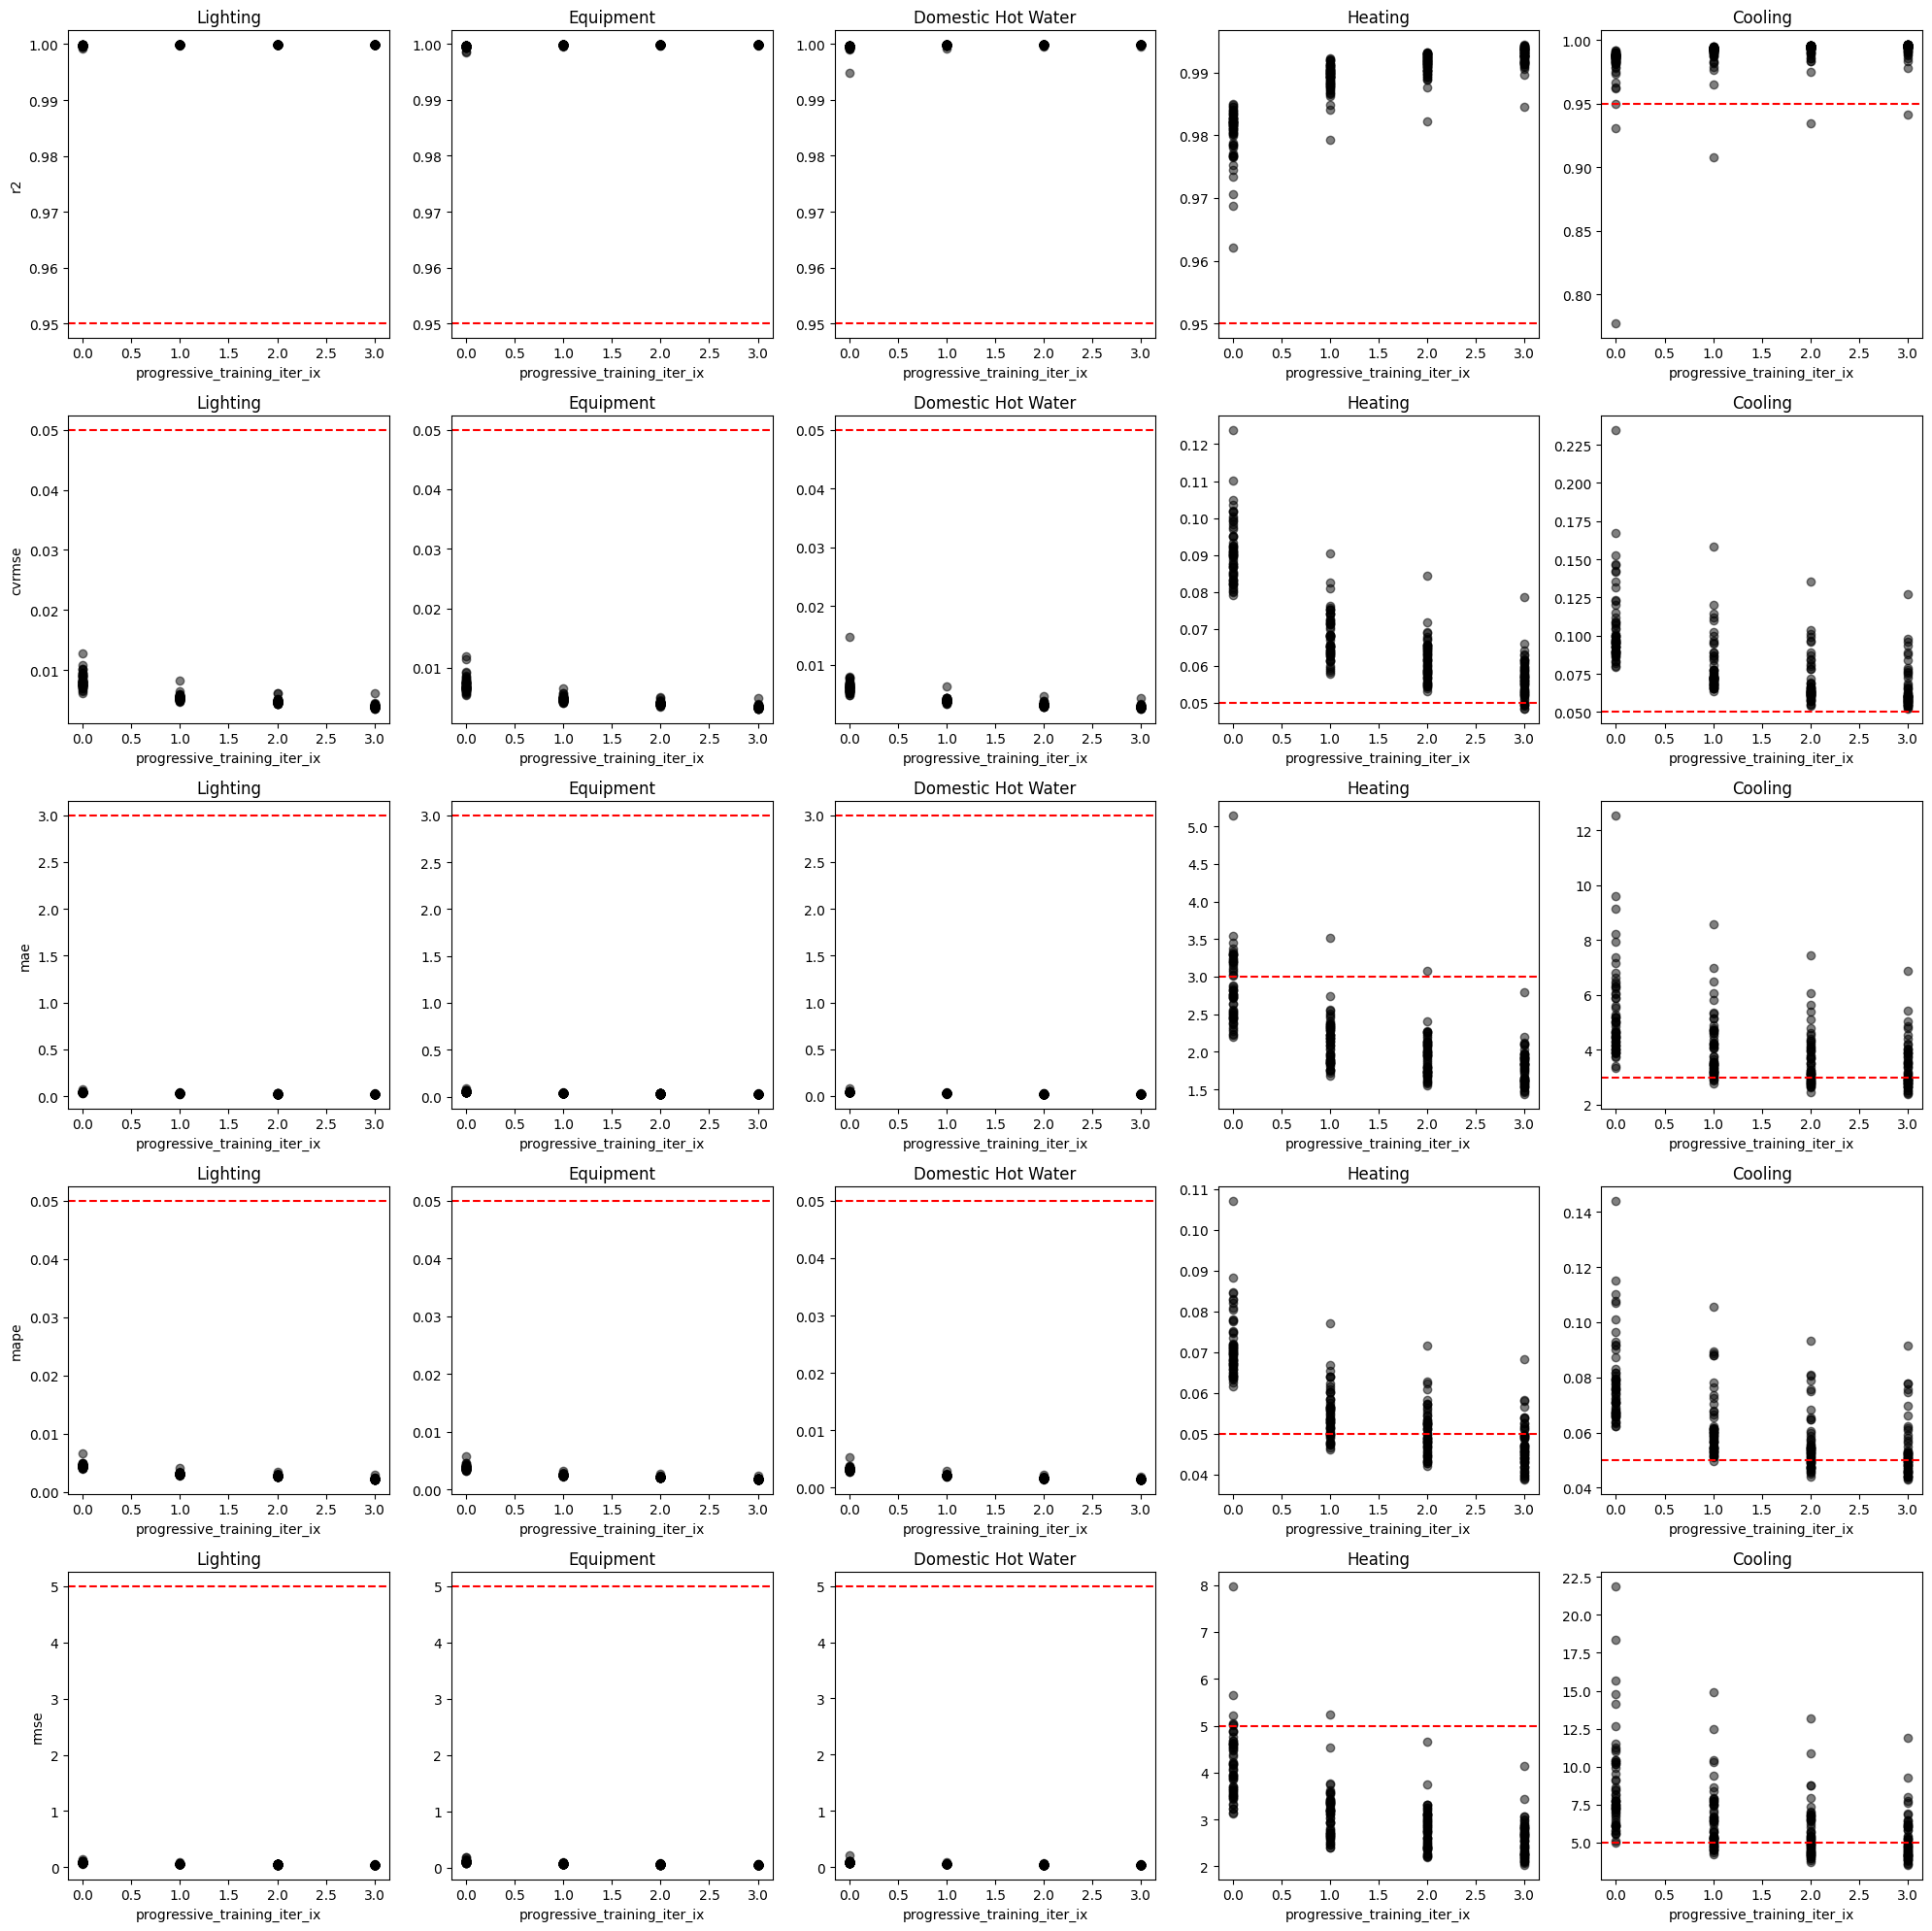

In [17]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 3,
    "rmse": 5,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.95,
}
# threshes = {
#     "mae": 1,
#     "rmse": 1,
#     "cvrmse": 0.05,
#     "mape": 0.05,
#     "r2": 0.95,
# }
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for row_ix, metric in enumerate(["r2", "cvrmse", "mae", "mape", "rmse"]):
    for col_ix, target in enumerate([
        "Lighting",
        "Equipment",
        "Domestic Hot Water",
        "Heating",
        "Cooling",
    ]):
        ax = axs[row_ix, col_ix]
        errs = (
            individual_fold_err_dfs.loc["Energy"]
            .groupby("progressive_training_iter_ix")
            .mean()["test"]
            .xs(metric, level="metric", axis=1)
            .xs(target, level="target", axis=1)
        )
        ax.set_title(target)
        errs.plot(
            marker="o",
            lw=0,
            legend=False,
            ax=ax,
            color="black",
            alpha=0.5,
        )
        ax.axhline(threshes[metric], color="red", linestyle="--")
        if col_ix == 0:
            ax.set_ylabel(metric)
fig.tight_layout()

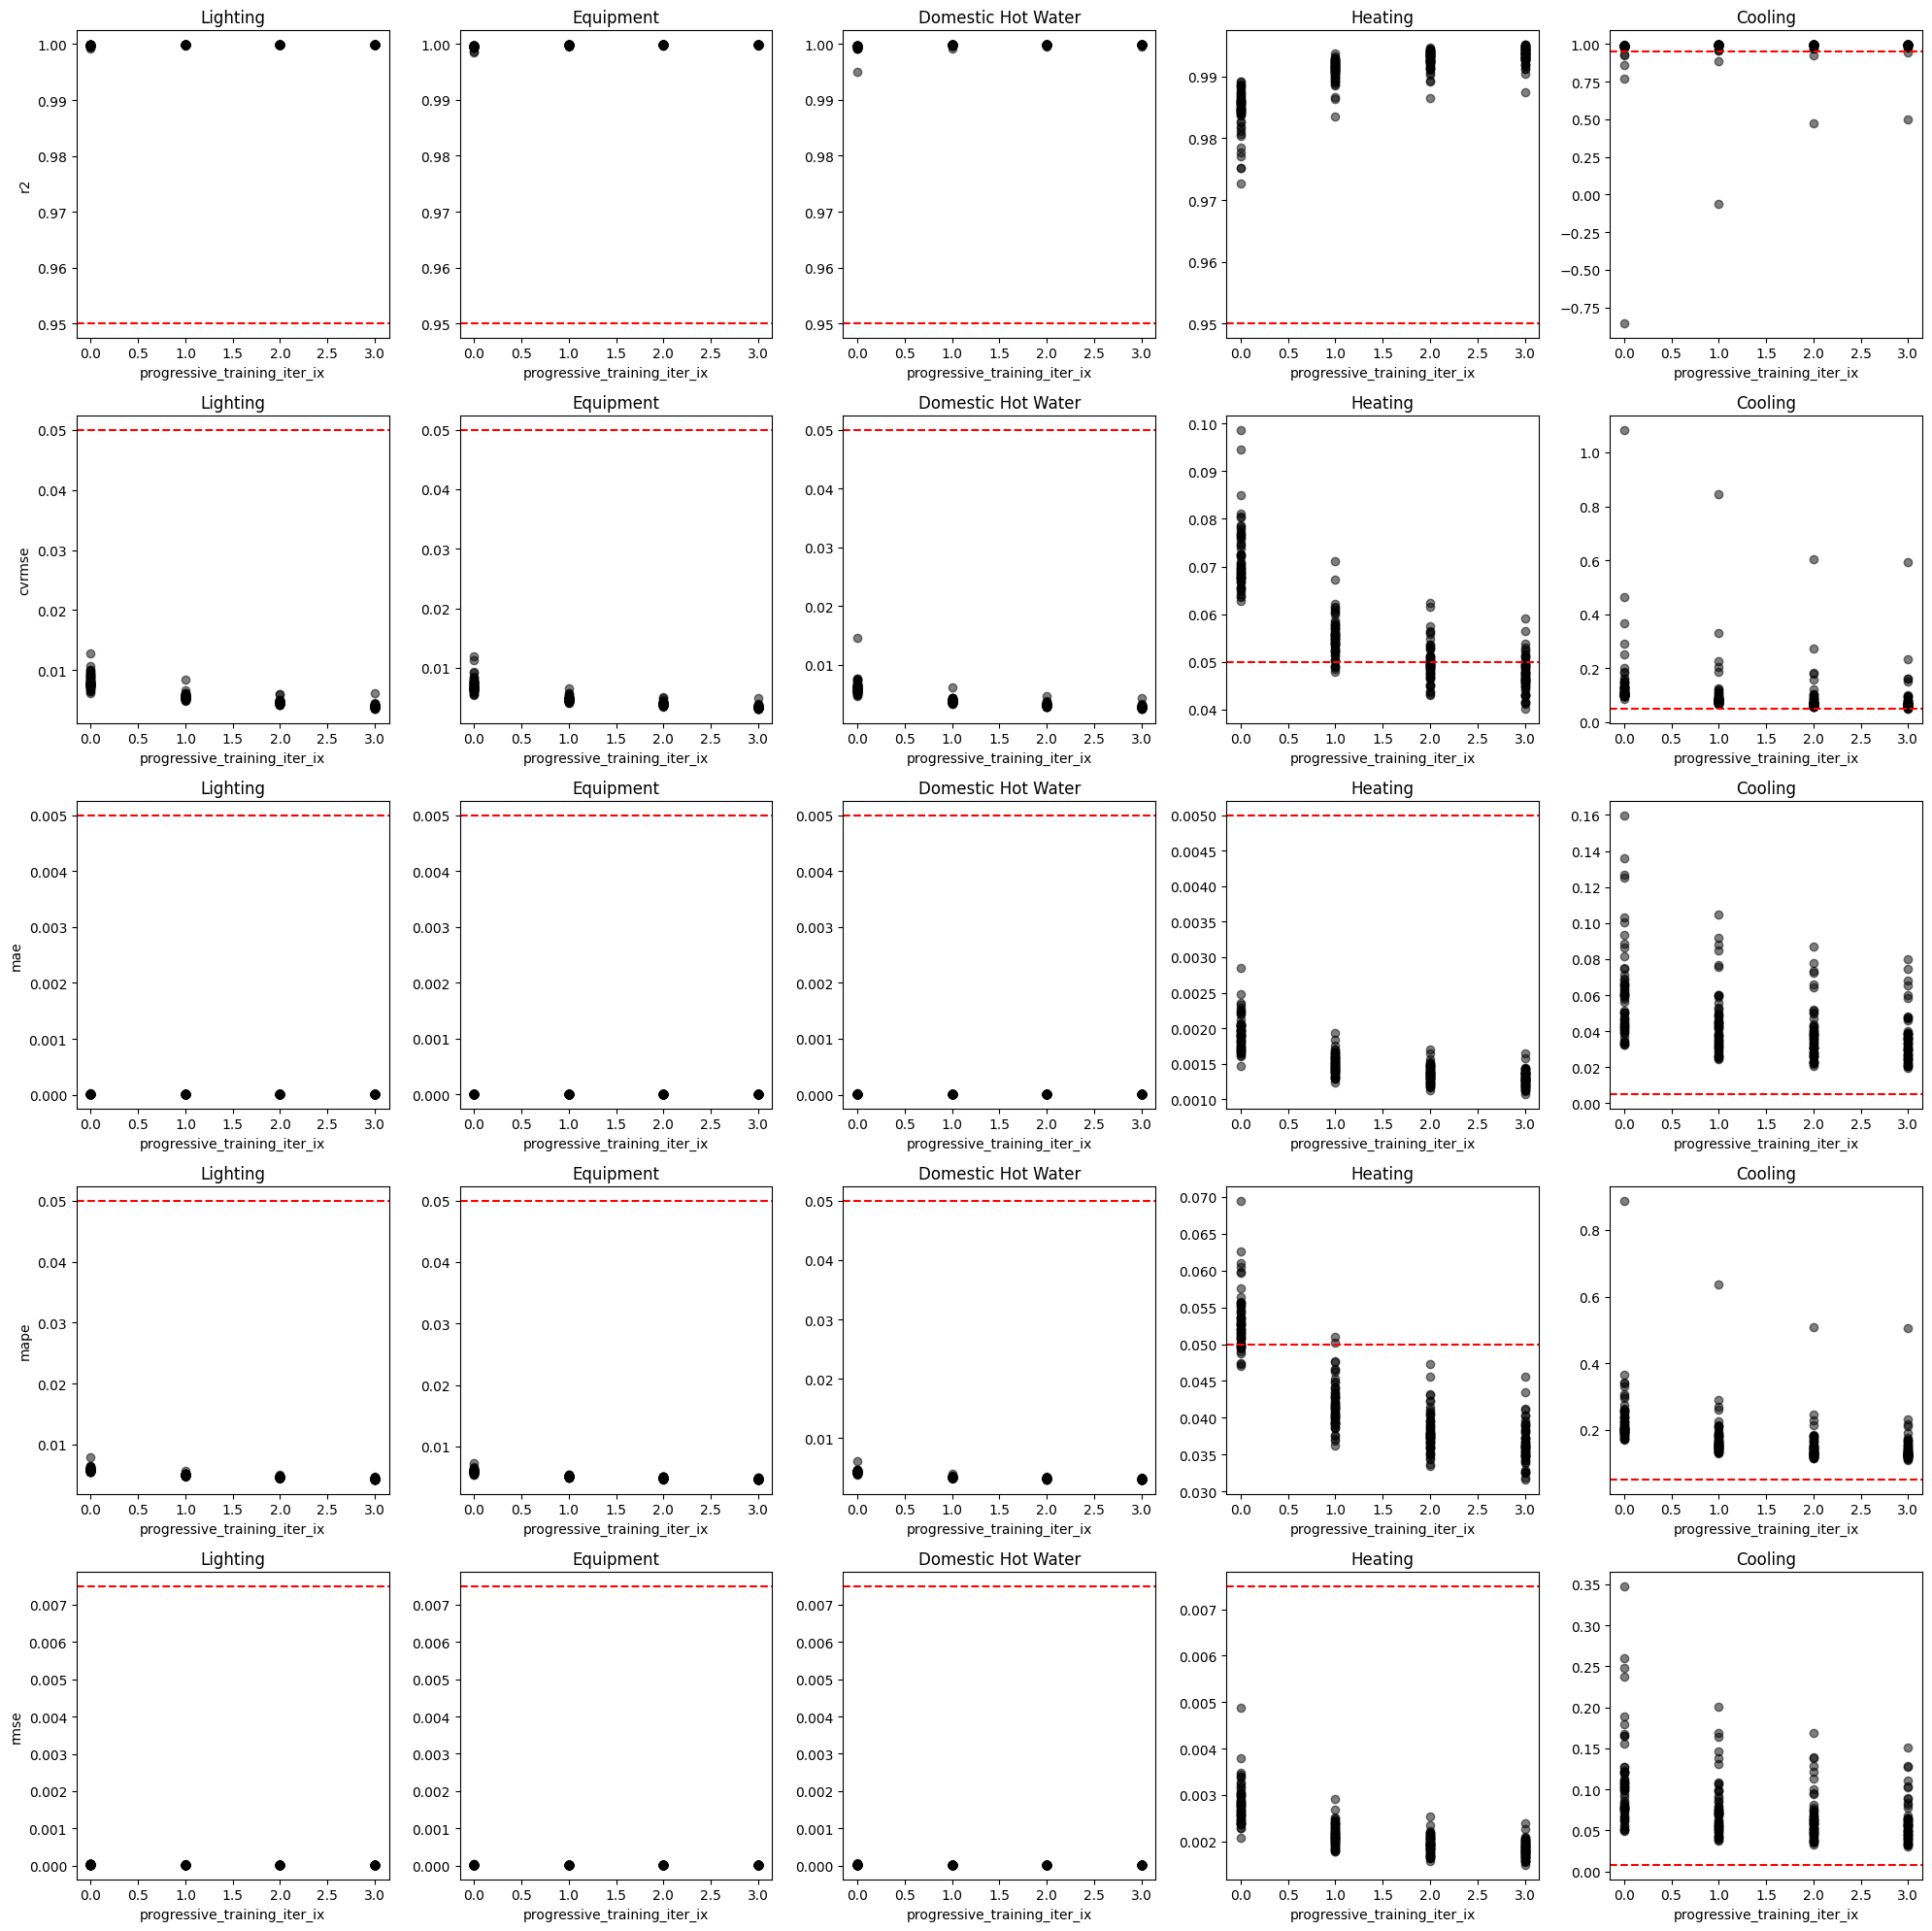

In [18]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 0.005,
    "rmse": 0.0075,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.95,
}
# threshes = {
#     "mae": 1,
#     "rmse": 1,
#     "cvrmse": 0.05,
#     "mape": 0.05,
#     "r2": 0.95,
# }
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for row_ix, metric in enumerate(["r2", "cvrmse", "mae", "mape", "rmse"]):
    for col_ix, target in enumerate([
        "Lighting",
        "Equipment",
        "Domestic Hot Water",
        "Heating",
        "Cooling",
    ]):
        ax = axs[row_ix, col_ix]
        errs = (
            individual_fold_err_dfs.loc["Peak"]
            .groupby("progressive_training_iter_ix")
            .mean()["test"]
            .xs(metric, level="metric", axis=1)
            .xs(target, level="target", axis=1)
        )
        ax.set_title(target)
        errs.plot(
            marker="o",
            lw=0,
            legend=False,
            ax=ax,
            color="black",
            alpha=0.5,
        )
        ax.axhline(threshes[metric], color="red", linestyle="--")
        if col_ix == 0:
            ax.set_ylabel(metric)
fig.tight_layout()

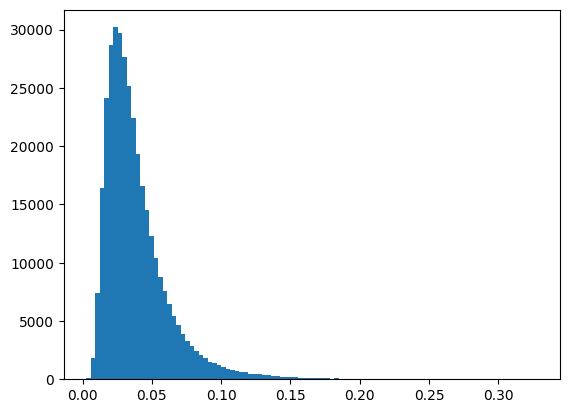

In [19]:
d = combined_sim_results_df["Peak"]["Raw"]["Heating"].max(axis=1).values.flatten()
d = d[d > 0]
_ = plt.hist(d, bins=100)

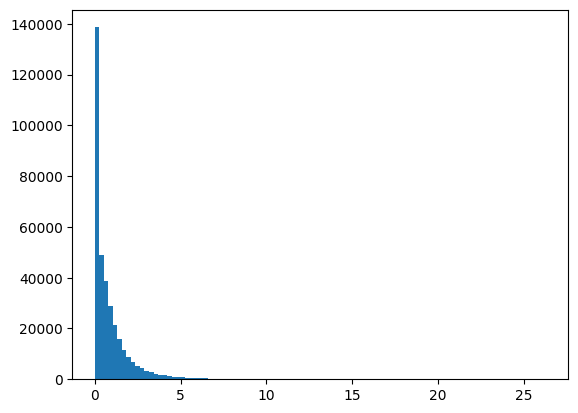

In [20]:
d = combined_sim_results_df["Peak"]["Raw"]["Cooling"].max(axis=1).values.flatten()
d = d[d > 0]
_ = plt.hist(d, bins=100)

(np.float64(12.335223241288734), np.float64(10.475799581069891))

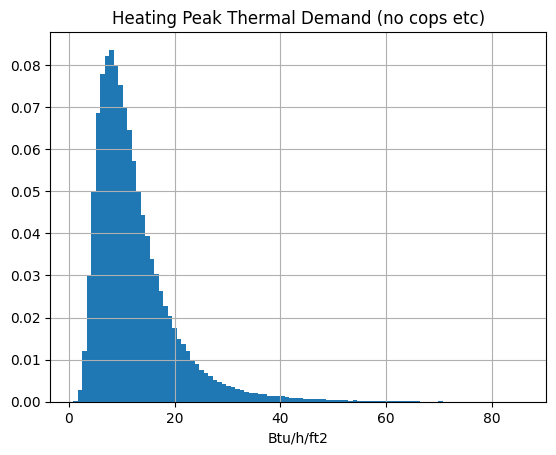

In [28]:
plt.title("Heating Peak Thermal Demand (no cops etc)")
data = (
    combined_sim_results_df["Peak"]["Raw"]
    .T.groupby("Meter")
    .max()
    .T.reset_index(drop=True)["Heating"]
    * 1000  # W/kW
    * 3.412  # Btu/h/W
    / 10.76391  # ft2/m2
)
data.hist(bins=100, density=True)
plt.xlabel("Btu/h/ft2")
mean = data.mean()
median = data.median()
mean, median

(np.float64(105.39841535749545), np.float64(120.1720005812294))

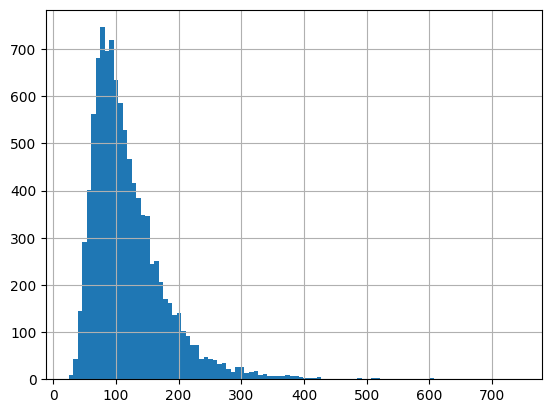

In [27]:
mask = combined_sim_results_df.index.get_level_values(
    "feature.weather.file"
).str.contains("Boston")

data = combined_sim_results_df.loc[(mask)]["Energy"]["Utilities"].sum(axis=1)
median = data.median()
mean = data.mean()
data.hist(bins=100)
median, mean

feature.semantic.Walls             feature.semantic.Weatherization
FullInsulationWallsCavityExterior  SomewhatLeakyEnvelope              32.420348
FullInsulationWallsCavity          SomewhatLeakyEnvelope              32.790820
FullInsulationWallsCavityExterior  TightEnvelope                      35.561025
FullInsulationWallsCavity          TightEnvelope                      35.835850
SomeInsulationWalls                SomewhatLeakyEnvelope              40.126128
                                   TightEnvelope                      43.011053
FullInsulationWallsCavityExterior  LeakyEnvelope                      50.256160
FullInsulationWallsCavity          LeakyEnvelope                      50.660806
SIP                                SomewhatLeakyEnvelope              53.032563
                                   TightEnvelope                      56.198175
UninsulatedWalls                   SomewhatLeakyEnvelope              58.901381
SomeInsulationWalls                LeakyEnvelope     

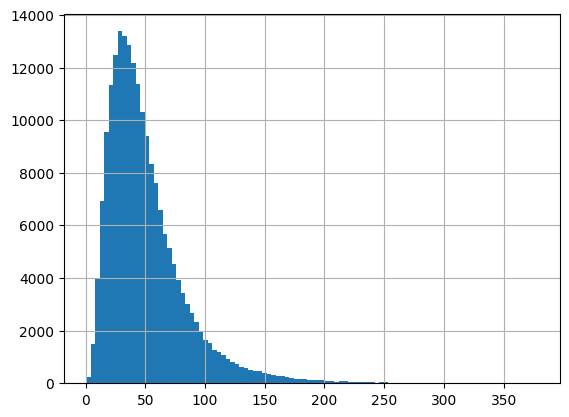

In [29]:
combined_sim_results_annual_raw = (
    combined_sim_results_df["Energy"]["Raw"].T.groupby("Meter").sum().T
)
combined_sim_results_annual_raw["Heating"].hist(bins=100)
combined_sim_results_annual_raw["Equipment"].groupby([
    "Typology",
    "Equipment",
    "Lighting",
]).std()
combined_sim_results_annual_raw["Heating"].groupby(["Typology"]).std()
combined_sim_results_annual_raw["Heating"].groupby([
    # "feature.semantic.Typology",
    "feature.semantic.Walls",
    "feature.semantic.Weatherization",
    # "feature.semantic.Thermostat",
]).mean().sort_values()

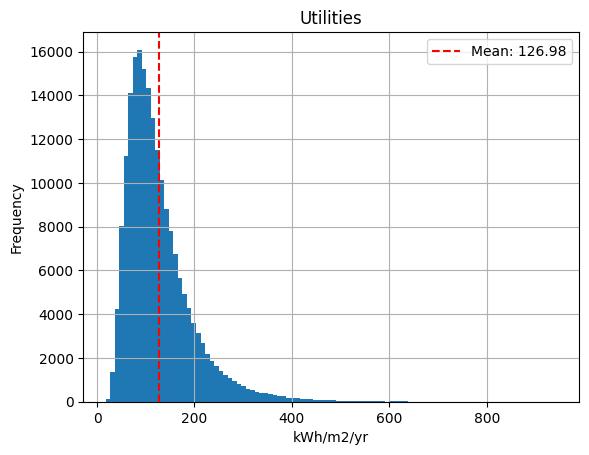

In [30]:
d = combined_sim_results_df["Energy"]["Utilities"].sum(axis=1)
fig, ax = plt.subplots()
d.hist(bins=100, ax=ax)
ax.axvline(d.mean(), color="red", linestyle="--", label=f"Mean: {d.mean():.2f}")
ax.set_xlabel("kWh/m2/yr")
ax.set_ylabel("Frequency")
ax.set_title("Utilities")
ax.legend()

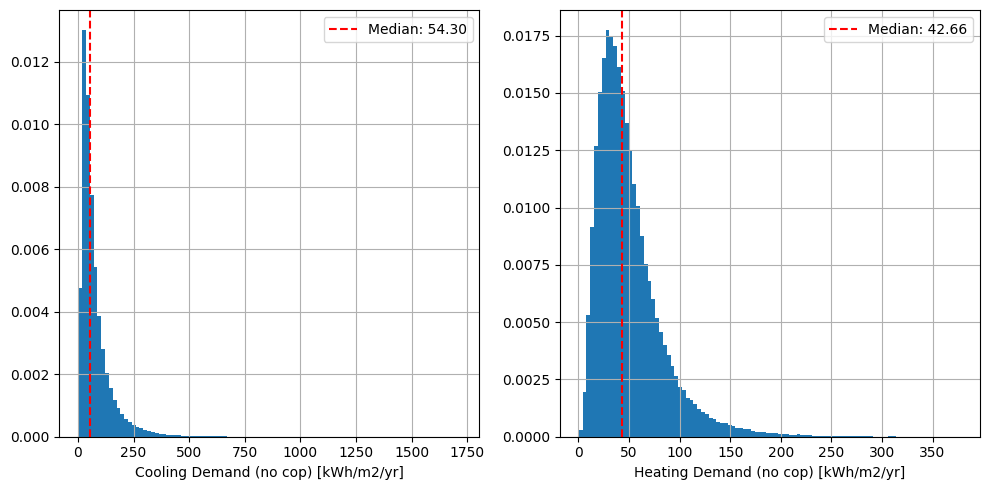

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
combined_sim_results_annual_raw["Cooling"].hist(bins=100, density=True, ax=ax[0])
ax[0].set_xlabel("Cooling Demand (no cop) [kWh/m2/yr]")

combined_sim_results_annual_raw["Heating"].hist(bins=100, density=True, ax=ax[1])
ax[1].set_xlabel("Heating Demand (no cop) [kWh/m2/yr]")
ax[0].axvline(
    combined_sim_results_annual_raw["Cooling"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {combined_sim_results_annual_raw['Cooling'].median():.2f}",
)
ax[1].axvline(
    combined_sim_results_annual_raw["Heating"].median(),
    color="red",
    linestyle="--",
    label=f"Median: {combined_sim_results_annual_raw['Heating'].median():.2f}",
)
ax[0].legend()
ax[1].legend()
fig.tight_layout()

In [34]:
combined_sim_results_annual_raw.groupby("feature.semantic.Weatherization").mean()

Meter,Cooling,Domestic Hot Water,Equipment,Heating,Lighting
feature.semantic.Weatherization,,,,,
LeakyEnvelope,93.560042,13.717816,15.382157,61.989957,10.553419
SomewhatLeakyEnvelope,95.689759,13.693207,15.391417,43.443690,10.546346
TightEnvelope,43.949893,13.691403,15.370064,46.286523,10.539124


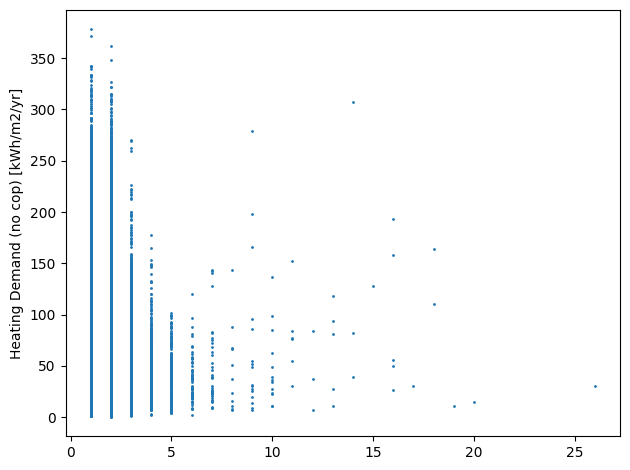

In [35]:
x = combined_sim_results_df.index.get_level_values("feature.geometry.num_floors").values
y = combined_sim_results_annual_raw["Heating"].values

fig, ax = plt.subplots()
ax.scatter(x, y, s=1)
# ax.set_xlabel("Total Conditioned Area [m2]")
ax.set_ylabel("Heating Demand (no cop) [kWh/m2/yr]")
# ax.set_xlim(0, 10000)
fig.tight_layout()

In [36]:
combined_sim_results_annual_raw.xs(
    "SomewhatLeakyEnvelope", level="feature.semantic.Weatherization"
).groupby([
    "feature.semantic.Age_bracket",
    "feature.semantic.Walls",
]).mean()["Heating"].sort_values()
# df.xs("USA_MA_Boston.994971_TMYx.2009-2023.zip", level="feature.weather.file").groupby(["feature.semantic.Typology", "feature.semantic.Age_bracket", "feature.semantic.Weatherization", ]).size()

feature.semantic.Age_bracket  feature.semantic.Walls           
post_2003                     FullInsulationWallsCavityExterior    30.733399
                              FullInsulationWallsCavity            31.335399
pre_1975                      FullInsulationWallsCavityExterior    31.835985
btw_1975_2003                 FullInsulationWallsCavity            32.988636
pre_1975                      FullInsulationWallsCavity            34.052912
btw_1975_2003                 FullInsulationWallsCavityExterior    34.681527
post_2003                     SomeInsulationWalls                  38.363256
btw_1975_2003                 SomeInsulationWalls                  39.003550
pre_1975                      SomeInsulationWalls                  43.055358
                              SIP                                  51.133481
btw_1975_2003                 SIP                                  53.723818
post_2003                     SIP                                  54.200252
            

In [37]:
combined_sim_results_annual_raw.groupby("feature.weather.file").mean()[
    "Heating"
].sort_values()

feature.weather.file
USA_MA_Chatham.Muni.AP.725069_TMYx.2009-2023                              36.010788
USA_MA_Woods.Hole.997274_TMYx.2009-2023                                   36.468782
USA_MA_Waquiot.Bay.Reserve.998014_TMYx.2009-2023                          37.217422
USA_MA_Nantucket.Island.994046_TMYx.2007-2021                             38.602228
USA_MA_Fall.River.Harbor.997279_TMYx.2004-2018                            39.981056
USA_MA_Barnstable.Muni.AP-Boardman.Polando.Field.725067_TMYx              40.552824
USA_MA_Marshfield.Muni.AP-Harlow.Field.722256_TMYx.2009-2023              40.980182
USA_RI_Providence.Harbor.997278_TMYx.2004-2018                            41.197057
USA_MA_Marthas.Vineyard.AP.725066_TMYx                                    41.542243
USA_MA_Boston.994971_TMYx.2009-2023                                       43.024397
USA_NY_Hudson.River.Reserve.997991_TMYx.2004-2018                         43.167170
USA_MA_Fall.River.Harbor.997279_TMYx                   

## Retraining

In [82]:
final_combined_sim_results_uri

's3://ml-for-bem/hatchet/ma-webapp/v2-20250507-151630/iter-000/sample/full-dataset.pq'

In [83]:
from epengine.models.train_sbem import TrainFoldSpec

spec = TrainFoldSpec(
    n_folds=5,
    data_uri=final_combined_sim_results_uri,
    stratification_field="feature.weather.file",
    progressive_training_iter_ix=0,
    experiment_id=experiment_id,
    sort_index=0,
    bucket="ml-for-bem",
)

In [84]:
train_features, train_targets = spec.train_segment
normalized_features = spec.normalize_params(train_features)
# for col in normalized_features.columns:
#     try:
#         col_vals = normalized_features[col].values.astype(float)
#         district_heating = train_targets["Heating"].values
#         correlation = np.corrcoef(col_vals, district_heating)[0, 1]
#         print(f"{col}: {correlation}")
#     except Exception as e:
#         print(type(col_vals))
#         print(f"{col} ERROR {e}")

In [85]:
train_features

np.float64(3.0001685487587104)

### LGB Curves

In [147]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from tqdm.autonotebook import tqdm

train_features, train_targets = spec.train_segment
test_features, test_targets = spec.test_segment
train_features_norm = spec.normalize_params(train_features)
test_features_norm = spec.normalize_params(test_features)

all_iter_err_dfs = []
for frac in tqdm(np.linspace(0.1, 1.0, 19), total=39):
    iter_err_dfs = {}
    for end_use in ["Heating", "Cooling"]:
        n_train = int(len(train_features_norm) * frac)
        n_test = len(test_features_norm)
        lgb_train_data = lgb.Dataset(
            train_features_norm.sample(frac=1, random_state=42).iloc[:n_train],
            label=train_targets[end_use].sample(frac=1, random_state=42).iloc[:n_train],
        )
        lgb_test_data = lgb.Dataset(
            test_features_norm.sample(frac=1, random_state=42).iloc[:n_test],
            label=test_targets[end_use].sample(frac=1, random_state=42).iloc[:n_test],
        )

        lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            # "max_depth": 5,
            # "learning_rate": 0.1,
            # "num_leaves": 100,
        }

        model = lgb.train(
            lgb_params,
            lgb_train_data,
            num_boost_round=4000,
            valid_sets=[lgb_test_data],
            valid_names=["eval"],
            callbacks=[lgb.early_stopping(20)],
        )

        test_preds = model.predict(test_features_norm)

        test_preds = pd.Series(test_preds, index=test_targets.index, name=end_use)
        test_trues = test_targets[end_use]

        residuals = test_trues - test_preds
        maes = {}
        mapes = {}
        r2s = {}
        cvrmses = {}
        for file in test_targets.index.get_level_values(
            "feature.weather.file"
        ).unique():
            test_trues_file = test_trues.xs(file, level="feature.weather.file")
            test_preds_file = test_preds.xs(file, level="feature.weather.file")
            mae = mean_absolute_error(test_trues_file, test_preds_file)
            mape = mean_absolute_percentage_error(test_trues_file, test_preds_file)
            r2 = r2_score(test_trues_file, test_preds_file)
            cvrmse = (
                np.sqrt(np.mean((test_trues_file - test_preds_file) ** 2))
                / test_trues_file.mean()
            )
            maes[file] = mae
            mapes[file] = mape
            r2s[file] = r2
            cvrmses[file] = cvrmse
        maes = pd.Series(maes, name="mae")
        mapes = pd.Series(mapes, name="mape")
        r2s = pd.Series(r2s, name="r2")
        cvrmses = pd.Series(cvrmses, name="cvrmse")
        iter_df = pd.concat([maes, mapes, r2s, cvrmses], axis=1)
        iter_df.index.name = "stratum"
        iter_df = iter_df.set_index(
            pd.Series([frac] * len(iter_df), name="frac"), append=True
        )
        iter_err_dfs[end_use] = iter_df
    iter_err_df = pd.concat(iter_err_dfs, axis=1, names=["metric"])
    all_iter_err_dfs.append(iter_err_df)

all_iter_err_dfs = pd.concat(all_iter_err_dfs, axis=0)
all_iter_err_dfs

159556 39919


KeyboardInterrupt: 

In [148]:
n_train, n_test

(159556, 39919)

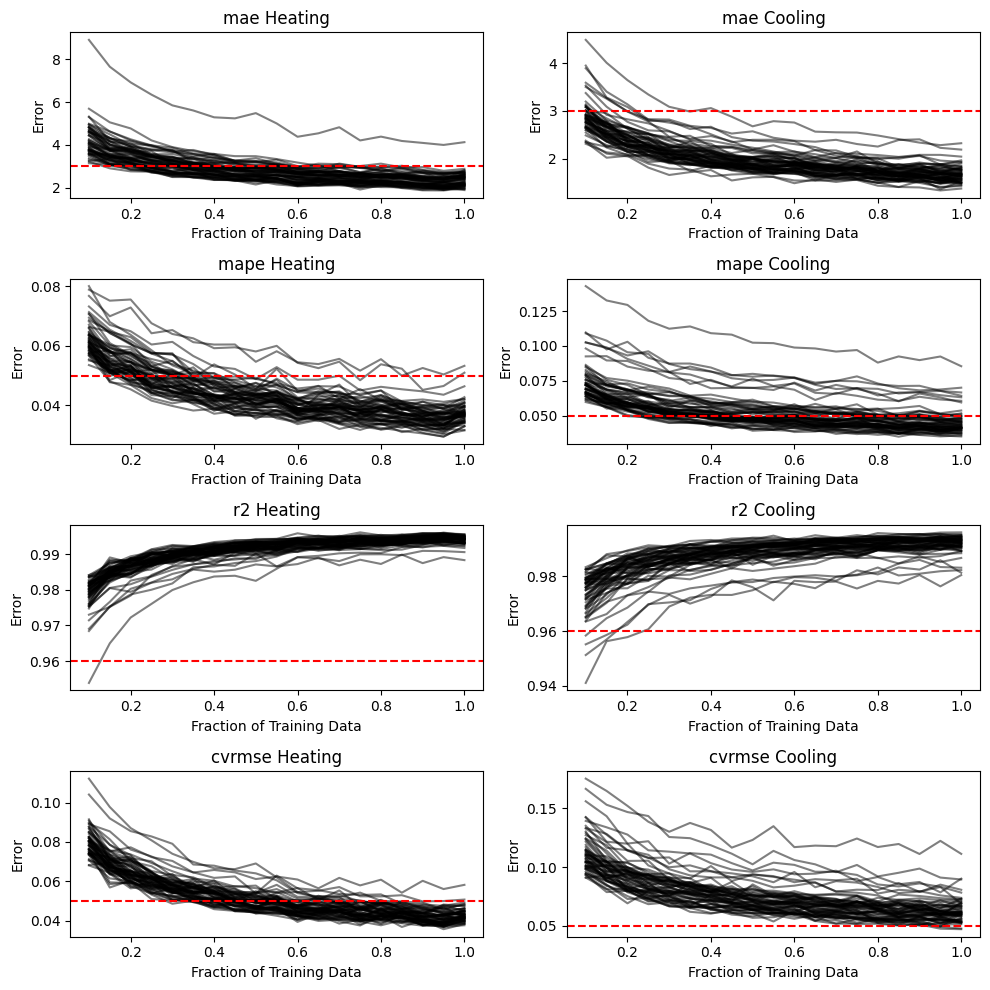

In [149]:
import matplotlib.pyplot as plt

threshes = {
    "mae": 3,
    "cvrmse": 0.05,
    "mape": 0.05,
    "r2": 0.96,
}
targets_to_plot = all_iter_err_dfs.columns.get_level_values(0).unique()
metrics_to_plot = all_iter_err_dfs.columns.get_level_values(1).unique()
fig, ax = plt.subplots(len(metrics_to_plot), len(targets_to_plot), figsize=(10, 10))
for i, metric in enumerate(metrics_to_plot):
    for j, target in enumerate(targets_to_plot):
        data_to_plot = all_iter_err_dfs.xs((target, metric), axis=1).unstack("stratum")
        data_to_plot.plot(ax=ax[i, j], legend=False, color="black", alpha=0.5)
        ax[i, j].axhline(threshes[metric], color="red", linestyle="--")
        ax[i, j].set_title(f"{metric} {target}")
        ax[i, j].set_xlabel("Fraction of Training Data")
        ax[i, j].set_ylabel("Error")
fig.tight_layout()

In [130]:
(
    len(
        spec.data.loc[
            spec.data.index.get_level_values("feature.geometry.short_edge") > 3
        ]
    ),
    len(spec.data),
)

(124587, 124587)

In [346]:
abs_errors = residuals.abs()
worst_semantic_features_fit = combined_sim_results_df.index.to_frame().loc[
    abs_errors.idxmax()
][
    [
        f
        for f in combined_sim_results_df.index.names
        if "feature.weather" not in f and "feature" in f
    ]
]
for feat, val in worst_semantic_features_fit.to_dict().items():
    print(feat, val)

feature.geometry.long_edge 5.271429784946954
feature.geometry.short_edge 3.701633178744034
feature.geometry.orientation 1.9927025937595322
feature.geometry.orientation.cos -0.4095003024173867
feature.geometry.orientation.sin 0.9123099814865936
feature.geometry.aspect_ratio 1.4240821633048883
feature.geometry.wwr 0.19633057497689138
feature.geometry.num_floors 22
feature.geometry.f2f_height 3.632544147914768
feature.geometry.zoning by_storey
feature.geometry.energy_model_conditioned_area 448.79668600172096
feature.geometry.energy_model_occupied_area 448.79668600172096
feature.geometry.attic_height 0.0
feature.geometry.shading_mask_00 0.0
feature.geometry.shading_mask_01 0.0
feature.geometry.shading_mask_02 0.0
feature.geometry.shading_mask_03 0.19065235328834984
feature.geometry.shading_mask_04 0.2358134957866958
feature.geometry.shading_mask_05 0.2187841647435257
feature.geometry.shading_mask_06 0.1979704124449433
feature.geometry.shading_mask_07 0.0
feature.geometry.shading_mask_08 0.

### LGB Full

In [88]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)

dataset = "Peak"
train_features, train_targets = spec.train_segment
test_features, test_targets = spec.test_segment
train_targets = train_targets[dataset]
test_targets = test_targets[dataset]
train_features_norm = spec.normalize_params(train_features)
test_features_norm = spec.normalize_params(test_features)
errs_dfs = {}
meters = ["Domestic Hot Water", "Lighting", "Equipment", "Heating", "Cooling"]
meters = ["Heating"]
for end_use in meters:
    lgb_train_data = lgb.Dataset(
        train_features_norm,
        label=train_targets[end_use],
    )
    lgb_test_data = lgb.Dataset(
        test_features_norm,
        label=test_targets[end_use],
    )

    lgb_params = {
        "objective": "regression",
        "metric": "rmse",
        # "max_depth": 5,
        # "learning_rate": 0.1,
        # "num_leaves": 100,
    }

    model = lgb.train(
        lgb_params,
        lgb_train_data,
        num_boost_round=4000,
        valid_sets=[lgb_test_data],
        valid_names=["eval"],
        callbacks=[lgb.early_stopping(20)],
    )

    test_preds = model.predict(test_features_norm)

    test_preds = pd.Series(test_preds, index=test_targets.index, name=end_use)
    test_trues = test_targets[end_use]

    residuals = test_trues - test_preds
    maes = {}
    mapes = {}
    r2s = {}
    cvrmses = {}
    for file in test_targets.index.get_level_values("feature.weather.file").unique():
        test_trues_file = test_trues.xs(file, level="feature.weather.file")
        test_preds_file = test_preds.xs(file, level="feature.weather.file")
        mae = mean_absolute_error(test_trues_file, test_preds_file)
        mape = mean_absolute_percentage_error(test_trues_file, test_preds_file)
        r2 = r2_score(test_trues_file, test_preds_file)
        cvrmse = (
            np.sqrt(np.mean((test_trues_file - test_preds_file) ** 2))
            / test_trues_file.mean()
        )
        maes[file] = mae
        mapes[file] = mape
        r2s[file] = r2
        cvrmses[file] = cvrmse
    maes = pd.Series(maes, name="mae")
    mapes = pd.Series(mapes, name="mape")
    r2s = pd.Series(r2s, name="r2")
    cvrmses = pd.Series(cvrmses, name="cvrmse")
    iter_df = pd.concat([maes, mapes, r2s, cvrmses], axis=1)
    iter_df.index.name = "stratum"
    errs_dfs[end_use] = iter_df
    with open(f"model_{dataset}_{end_use.replace(' ', '_')}.lgb", "w") as f:
        f.write(model.model_to_string())

err_summary = pd.concat(errs_dfs, axis=1, names=["target"])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19678
[LightGBM] [Info] Number of data points in the train set: 159821, number of used features: 190
[LightGBM] [Info] Start training from score 0.067215
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1968]	eval's rmse: 0.00258779


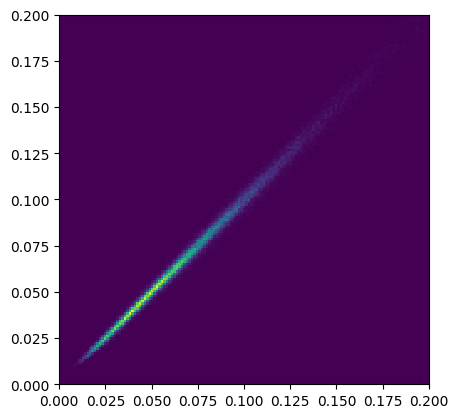

In [91]:
import matplotlib.pyplot as plt

end_use = "Heating"
with open(f"model_{dataset}_{end_use.replace(' ', '_')}.lgb") as f:
    model = lgb.Booster(model_str=f.read())
preds = model.predict(test_features_norm)
trues = test_targets[end_use]
_ = plt.hist2d(preds, trues, bins=np.linspace(0, 0.2, 150))
plt.gca().set_aspect("equal")

### Design Space

In [31]:
for k, v in spec.numeric_min_maxs.items():
    print(k, v)

feature.geometry.long_edge (np.float64(1.8587820232992796), np.float64(204.68179807521815))
feature.geometry.short_edge (np.float64(0.6891672242615761), np.float64(113.49737283820672))
feature.geometry.orientation (np.float64(-3.141582071355473), np.float64(3.1415757612439017))
feature.geometry.orientation.cos (np.float64(-0.9999999999440081), np.float64(0.9999999999897445))
feature.geometry.orientation.sin (np.float64(-0.9999999999962115), np.float64(0.9999999989522861))
feature.geometry.aspect_ratio (np.float64(1.0000031375464564), np.float64(10.810115012699804))
feature.geometry.wwr (np.float64(0.10000053553035589), np.float64(0.29999815390342977))
feature.geometry.num_floors (np.int64(1), np.int64(20))
feature.geometry.f2f_height (np.float64(2.5000164724717124), np.float64(3.9999856490795986))
feature.geometry.energy_model_conditioned_area (np.float64(3.0360651789362496), np.float64(63353.018979244065))
feature.geometry.energy_model_occupied_area (np.float64(3.0360651789362496), np

In [64]:
from epengine.models.transforms import (
    CategoricalFeature,
    ContinuousFeature,
    RegressorInputSpec,
)

feats = []
for feat in spec.train_segment[0].columns:
    if feat in spec.non_numeric_options:
        feats.append(
            CategoricalFeature(name=feat, values=spec.non_numeric_options[feat])
        )
    elif feat in spec.numeric_min_maxs:
        low, high = spec.numeric_min_maxs[feat]
        feats.append(ContinuousFeature(name=feat, min=float(low), max=float(high)))

ds = RegressorInputSpec(features=feats)
import yaml

with open("space.yml", "w") as f:
    yaml.dump(ds.model_dump(), f, indent=2, sort_keys=False)

[
    f.name
    for f in ds.features
    if "weather" not in f.name and "shading_mask" not in f.name
]
[f.name for f in ds.features if "weather" in f.name]

['feature.weather.file',
 'feature.weather.annual.daily_max_median',
 'feature.weather.annual.daily_median_median',
 'feature.weather.annual.daily_min_median',
 'feature.weather.annual.daily_range_median',
 'feature.weather.annual.dd_cooling',
 'feature.weather.annual.dd_heating',
 'feature.weather.latitude',
 'feature.weather.longitude',
 'feature.weather.monthly.daily_max.01',
 'feature.weather.monthly.daily_max.02',
 'feature.weather.monthly.daily_max.03',
 'feature.weather.monthly.daily_max.04',
 'feature.weather.monthly.daily_max.05',
 'feature.weather.monthly.daily_max.06',
 'feature.weather.monthly.daily_max.07',
 'feature.weather.monthly.daily_max.08',
 'feature.weather.monthly.daily_max.09',
 'feature.weather.monthly.daily_max.10',
 'feature.weather.monthly.daily_max.11',
 'feature.weather.monthly.daily_max.12',
 'feature.weather.monthly.daily_max_median.01',
 'feature.weather.monthly.daily_max_median.02',
 'feature.weather.monthly.daily_max_median.03',
 'feature.weather.month

In [58]:
ds = {
    "categorical": spec.non_numeric_options,
    "continuous": {
        k: (float(low), float(high)) for k, (low, high) in spec.numeric_min_maxs.items()
    },
    "params": sorted(
        list(spec.non_numeric_options.keys()) + list(spec.numeric_min_maxs.keys()),
        key=lambda x: spec.train_segment[0].columns.tolist().index(x),
    ),
}
import json

print(json.dumps(ds, indent=4))

{
    "categorical": {
        "feature.geometry.zoning": [
            "by_storey",
            "core/perim"
        ],
        "feature.semantic.DHW": [
            "ElectricResistanceDHW",
            "HPWH",
            "NaturalGasDHW",
            "NaturalGasHeatingDHWCombo"
        ],
        "feature.semantic.Walls": [
            "FullInsulationWallsCavity",
            "FullInsulationWallsCavityExterior",
            "SIP",
            "SomeInsulationWalls",
            "UninsulatedWalls"
        ],
        "feature.semantic.Region": [
            "MA"
        ],
        "feature.semantic.Cooling": [
            "ACCentral",
            "ACWindow",
            "ASHPCooling",
            "GSHPCooling",
            "WindowASHP"
        ],
        "feature.semantic.Heating": [
            "ASHPHeating",
            "ElectricResistance",
            "GSHPHeating",
            "NaturalGasCondensingHeating",
            "NaturalGasHeating",
            "OilHeating"
        ],
      

In [29]:
for k, v in spec.non_numeric_options.items():
    print(k, v)

feature.geometry.zoning ['by_storey', 'core/perim']
feature.semantic.DHW ['ElectricResistanceDHW', 'HPWH', 'NaturalGasDHW', 'NaturalGasHeatingDHWCombo']
feature.semantic.Walls ['FullInsulationWallsCavity', 'FullInsulationWallsCavityExterior', 'SIP', 'SomeInsulationWalls', 'UninsulatedWalls']
feature.semantic.Region ['MA']
feature.semantic.Cooling ['ACCentral', 'ACWindow', 'ASHPCooling', 'GSHPCooling', 'WindowASHP']
feature.semantic.Heating ['ASHPHeating', 'ElectricResistance', 'GSHPHeating', 'NaturalGasCondensingHeating', 'NaturalGasHeating', 'OilHeating']
feature.semantic.Windows ['DoublePaneLowE', 'SinglePane', 'SinglePaneStormWindows', 'TriplePaneLowE']
feature.semantic.Lighting ['LED', 'NoLED']
feature.semantic.Typology ['MFH', 'SFH']
feature.semantic.Equipment ['HighEfficiencyEquipment', 'LowEfficiencyEquipment']
feature.semantic.Thermostat ['Controls', 'NoControls']
feature.semantic.Age_bracket ['btw_1975_2003', 'post_2003', 'pre_1975']
feature.semantic.Distribution ['AirDuctsCon

<Axes: >

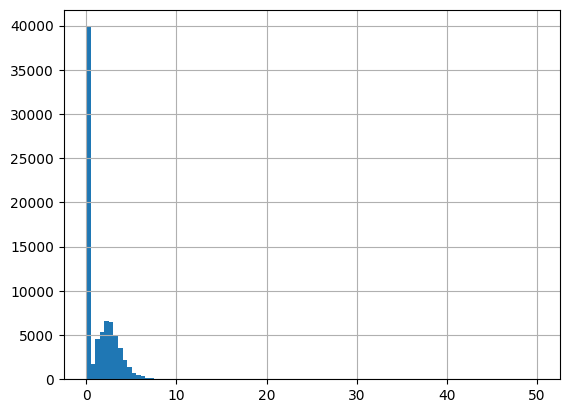

In [ ]:
train_features["feature.geometry.attic_height"].hist(bins=(np.linspace(0, 50, 100)))

np.float64(0.019093262256849226)

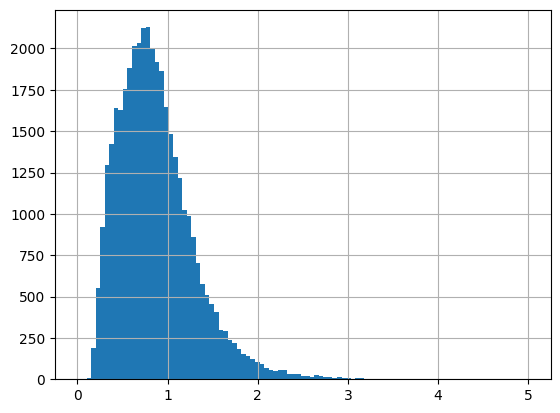

In [53]:
attic_heights = train_features["feature.geometry.attic_height"]
f2f_heights = train_features["feature.geometry.f2f_height"]
ratio = attic_heights / f2f_heights
ratio = ratio[ratio > 0]
ratio.hist(bins=np.linspace(0, 5, 100))
(ratio > 2).mean()

<Axes: >

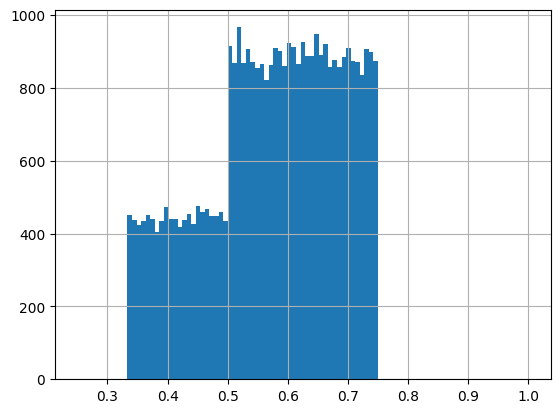

In [50]:
attic_heights = train_features["feature.geometry.attic_height"]
short_edges = train_features["feature.geometry.short_edge"] / 2
(attic_heights / short_edges).hist(bins=np.linspace(3 / 12, 12 / 12, 100))

# Old IDF File Stuff

In [145]:
import asyncio

from archetypal.idfclass import IDF
from epinterface.geometry import match_idf_to_building_and_neighbors

from epengine.models.shoebox import ShoeboxSimulationSpec

df_old = pd.read_parquet(
    "s3://ml-for-bem/hatchet/massachusetts/2024_09_30/residential-v2/specs/832ee29a-1a76-4126-9c83-f08171b5899a/832ee29a-1a76-4126-9c83-f08171b5899a_specs_000000.pq"
)
k = 17
spec_old = ShoeboxSimulationSpec(**df_old.iloc[k].to_dict())

f2f_height = 3.5
model = spec_old.configure(f2f_height=f2f_height)
model.geometry.w, model.geometry.d = model.geometry.d, model.geometry.w

# create a global variable to cache the idf
my_idf: IDF | None = None


def post_build_callback(idf: IDF) -> IDF:
    idf = match_idf_to_building_and_neighbors(
        idf,
        building=spec_old.rotated_rectangle,
        neighbor_polys=spec_old.neighbor_polys,  # pyright: ignore [reportArgumentType]
        neighbor_floors=spec_old.neighbor_floors,  # pyright: ignore [reportArgumentType]
        neighbor_f2f_height=f2f_height,
        target_long_length=spec_old.long_edge,
        target_short_length=spec_old.short_edge,
        rotation_angle=spec_old.long_edge_angle,
    )
    global my_idf
    my_idf = idf
    return idf


weather_dir = Path("notebooks") / "weather"
weather_dir.mkdir(parents=True, exist_ok=True)
from epinterface.climate_studio.builder import SimulationPathConfig

temp_dir = Path("cache") / "temptest"
output_dir = Path(temp_dir)
config = (
    SimulationPathConfig(
        output_dir=output_dir,
        weather_dir=weather_dir,
    )
    if weather_dir is not None
    else SimulationPathConfig(output_dir=output_dir)
)

try:
    idf, sql = await asyncio.to_thread(
        model.simulate,
        config=config,
        post_build_callback=post_build_callback,
    )
except Exception as e:
    print(e)

Adding lights to zone with schedule MA_LIGHTS_SCHEDULE.  Make sure this schedule exists.
Ignoring IlluminanceTarget for zone(s) Conditioned_Zones.
Adding people to zone with schedule MA_OCC_SCH.  Make sure this schedule exists.
Ignoring AirspeedSchedule for zone(s) Conditioned_Zones.
Adding equipment to zone with schedule MA_EQUIP_SCHEDULE.  Make sure this schedule exists.
Mechanical ventilation schedule is being ignored in zone Block shoebox Storey 0.
Exception in thread ExpandObjects_Minimal.idf:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "e:\repos\epengine\.venv\lib\site-packages\archetypal\eplus_interface\expand_objects.py", line 63, in run
    self.p = subprocess.Popen(
  File "C:\tools\Anaconda3\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\tools\Anaconda3\lib\subprocess.py", line 1440, in _execute_child
    hp, ht, pid

C:\EnergyPlusV22-2-0\energyplus.exe Minimal.idf: 0it [00:00, ?it/s]

e:\repos\epengine\notebooks\cache\temptest\Minimal.idf:
Program Version,EnergyPlus, Version 22.2.0-c249759bad, YMD=2025.03.19 13:24,
   ** Severe  ** HVACTemplate:* objects found. These objects are not supported directly by EnergyPlus.
   **   ~~~   ** You must run the ExpandObjects program on this input.
   **  Fatal  ** Errors occurred on processing input file. Preceding condition(s) cause termination.
   ...Summary of Errors that led to program termination:
   ..... Reference severe error count=1
   ..... Last severe error=HVACTemplate:* objects found. These objects are not supported directly by EnergyPlus.
   ************* Warning:  Node connection errors not checked - most system input has not been read (see previous warning).
   ************* Fatal error -- final processing.  Program exited before simulations began.  See previous error messages.
   ************* EnergyPlus Warmup Error Summary. During Warmup: 0 Warning; 0 Severe Errors.
   ************* EnergyPlus Sizing Error Su

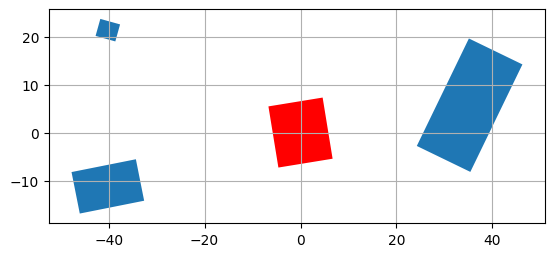

In [146]:
from shapely import from_wkt

rotated_rectangle = from_wkt(spec_old.rotated_rectangle)
neighbor_polys = [from_wkt(poly) for poly in spec_old.neighbor_polys]
import geopandas as gpd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ne = gpd.GeoSeries(neighbor_polys)
bu = gpd.GeoSeries(rotated_rectangle)
ne.translate(xoff=-bu.iloc[0].centroid.x, yoff=-bu.iloc[0].centroid.y).plot(ax=ax)
bu.translate(xoff=-bu.iloc[0].centroid.x, yoff=-bu.iloc[0].centroid.y).plot(
    ax=ax, color="red"
)
ax.grid()

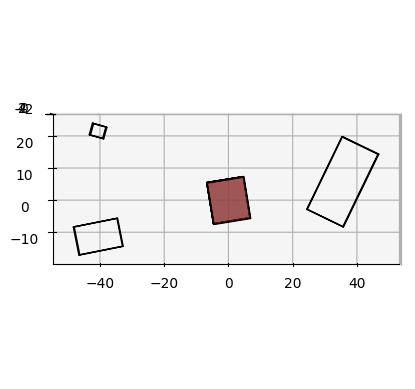

In [147]:
from geomeppy.view_geometry import _get_collection, _get_surfaces

surfaces = _get_surfaces(my_idf)
# set up the collections
walls = _get_collection("wall", surfaces, 0.5, facecolor="lightyellow")
floors = _get_collection("floor", surfaces, 0.5, facecolor="dimgray")
roofs = _get_collection("roof", surfaces, 0.5, facecolor="firebrick")
windows = _get_collection("window", surfaces, 0.5, facecolor="cornflowerblue")
shading = _get_collection("shading", surfaces, 1, facecolor="darkolivegreen")

ax = plt.axes(projection="3d")
ax.add_collection3d(floors)
ax.add_collection3d(walls)
ax.add_collection3d(roofs)
ax.add_collection3d(windows)
ax.add_collection3d(shading)
ax.view_init(elev=90, azim=-90)
ax.set_aspect("equal")
# set the view to be in plane, i.e. from above

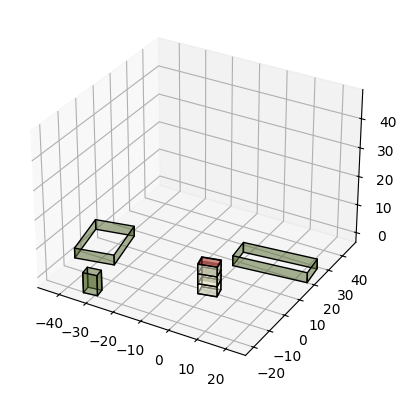

In [136]:
fig, ax = my_idf.view_model()